Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

Files and Field Descriptions
train.csv - The training set.
Id Unique identifier for each observation.
AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
test.csv - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
greeks.csv - Supplemental metadata, only available for the training set.
Alpha Identifies the type of age-related condition, if present.
A No age-related condition. Corresponds to class 0.
B, D, G The three age-related conditions. Correspond to class 1.
Beta, Gamma, Delta Three experimental characteristics.
Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.
sample_submission.csv - A sample submission file in the correct format. See the Evaluation page for more details.

#### Notes

Positive class is minority. About 20% are positive

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
# !pip install xgboost
import xgboost as xgb
import tensorflow as tf
tf.random.set_seed(42)

2024-08-10 12:30:04.462965: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 12:30:04.478519: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 12:30:04.514436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 12:30:04.559506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 12:30:04.572045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 12:30:04.636397: I tensorflow/core/platform/cpu_feature_gu

In [2]:
data = pd.read_csv("data/train.csv", index_col="Id").dropna() # EJ is categorical
ej_bins = data.EJ.map({"A": 0, "B": 1})
data.EJ = ej_bins

greeks = pd.read_csv("data/greeks.csv", index_col="Id")

In [103]:
# data = data.merge(greeks[["Beta", "Gamma", "Delta"]], left_index=True, right_index=True)

### Preprocessing

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("Class", axis=1), data.Class, test_size=0.1, random_state=42, stratify=data.Class)

In [4]:
smote = SMOTE(random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [5]:
scaler = MinMaxScaler()
X_train_resample = scaler.fit_transform(X_train_resample)
X_test = scaler.transform(X_test)

In [ ]:
# pipeline = Pipeline((smote, scaler))

### Neural Network

In [12]:
_input = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(500, activation="relu")(_input)
hidden_layer_2 = Dense(250, activation="relu")(hidden_layer_1)
hidden_layer_3 = Dense(250, activation="relu")(hidden_layer_2)
output_layer = Dense(1, activation="sigmoid")(hidden_layer_3)

model = Model(_input, output_layer)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "precision", "recall"])

In [13]:
# early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.fit(X_train_resample, y_train_resample, validation_split=0.2, epochs=10)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5630 - loss: 0.6543 - precision: 0.4387 - recall: 0.2747 - val_accuracy: 0.2958 - val_loss: 0.8441 - val_precision: 1.0000 - val_recall: 0.2958
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7735 - loss: 0.4485 - precision: 0.8255 - recall: 0.5425 - val_accuracy: 0.7746 - val_loss: 0.4362 - val_precision: 1.0000 - val_recall: 0.7746
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8382 - loss: 0.3709 - precision: 0.8343 - recall: 0.7384 - val_accuracy: 0.7254 - val_loss: 0.4639 - val_precision: 1.0000 - val_recall: 0.7254
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8722 - loss: 0.2831 - precision: 0.8391 - recall: 0.8388 - val_accuracy: 0.8732 - val_loss: 0.3070 - val_precision: 1.0000 - val_recall: 0.8732
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9077 - loss: 0.2294 - precision: 0.8969 - recall: 0.8661 - val_accuracy: 0.8873 - val_loss: 0.2655 

In [15]:
model.evaluate(X_test, y_test, verbose=2)

4/4 - 0s - 14ms/step - accuracy: 0.9091 - loss: 1.0600 - precision: 0.9000 - recall: 0.5000


[1.0599696636199951, 0.9090909361839294, 0.8999999761581421, 0.5]

In [88]:
model.save("tf_model.keras")

### XGBoost

Learning from parameters:

Too low a learning rate means that validation loss and other metrics perform much worse. The model is not converging, it is learning too slowly with a low learning rate.
A learning rate of 1 performs better than low ones like 0.01, or 0.1.

In [4]:
def balanced_log_loss(estimator, test_x, test_y):
    preds_proba = estimator.predict_proba(test_x)
    preds = preds_proba[:, 1]
    # Ensure predictions are within valid range
    pred_y = np.clip(preds, 1e-15, 1 - 1e-15)
    
    # Number of positive and negative samples
    n_pos = np.sum(test_y == 1)
    n_neg = np.sum(test_y == 0)
    
    # Compute the weighted log loss for positive and negative samples
    pos_loss = -np.sum(test_y * np.log(preds)) / n_pos
    neg_loss = -np.sum((1 - test_y) * np.log(1 - preds)) / n_neg
    
    # Balanced log loss
    balanced_loss = 0.5 * (pos_loss + neg_loss)
    
    return balanced_loss

In [5]:
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgbrf = xgb.sklearn.XGBRFClassifier(
    objective="binary:logistic", 
    random_state=42,
    n_estimators=500,
    # max_depth=9,
    learning_rate=1,
    # reg_alpha=0.01,
    # reg_lambda=0.01,
    )

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 9],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1],
    'gamma': [0, 0.01, 0.1, 1, 1.5, 2, 5],
}

random_search = RandomizedSearchCV(
    estimator=xgbrf,
    param_distributions=param_dist,
    n_iter=100,
    cv=cv,
    scoring=balanced_log_loss,  
    verbose=2,   
    random_state=42,
    n_jobs=-1    
)

random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-logloss:0.32891
[CV] END gamma=0, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1; total time=   1.0s
[0]	validation_0-logloss:0.35332
[CV] END gamma=0, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1; total time=   1.1s
[0]	validation_0-logloss:0.29426
[CV] END gamma=0, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1; total time=   1.1s
[0]	validation_0-logloss:0.29354
[CV] END gamma=0, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1; total time=   1.1s
[0]	validation_0-logloss:0.34892
[CV] END gamma=1, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   0.3s
[0]	validation_0-logloss:0.37222
[CV] END gamma=1, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   0.4s
[0]	validation_0-logloss:0.32414
[CV] END gamma=1, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   0.3s
[0]	validation_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBRFClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interac...
                                             n_estimators=500, n_jobs=None,
                                             num_parallel_tree=None,
                                             objective='binary:logistic',
                                             random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.01, 0.1, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5, 6, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0.01, 0.1, 1]},
                   random_state=42,
                   scoring=<function balanced_log_loss at 0x7f308e568400>,
                   verbose=2)

In [7]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_pred))
print("Balanced Log Loss:", balanced_log_loss(best_model, X_test, y_test))


Accuracy: 0.8363636363636363
Precision: 0.6666666666666666
AUC: 0.5888888888888889
Log Loss: 5.898052372764625
Balanced Log Loss: 0.7405165990193685


In [9]:
best_model.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1,
 'reg_lambda': 1,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 2,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [34]:
best_model

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=42, reg_alpha=0.1, ...)

### Random Forest

In [4]:
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],          
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],             
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True, False]                 
}
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  
    cv=5,        
    verbose=2,   
    random_state=42,
    n_jobs=-1    
)

In [5]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_feat

/home/tristannew/.pyenv/versions/3.12.2/envs/kaggle_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
74 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tristannew/.pyenv/versions/3.12.2/envs/kaggle_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tristannew/.pyenv/versions/3.12.2/envs/kaggle_env/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/tristannew/.pyenv/versions/3.12.2/envs/kaggl

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200,
                                                         300]},
                   random_state=42, verbose=2)

In [6]:
best_model = random_search.best_estimator_

In [7]:
preds = best_model.predict(X_test)
pred_probas = best_model.predict_proba(X_test)

In [8]:
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds))
print("AUC:", roc_auc_score(y_test, preds))
print("Log Loss:", log_loss(y_true=y_test,y_pred=preds))

Accuracy: 0.9090909090909091
Precision: 1.0
AUC: 0.7222222222222222
Log Loss: 3.2766957626470137


In [9]:
test = pd.read_csv("data/test.csv", index_col="Id")
ej_bins = test.EJ.map({"A": 0, "B": 1})
test.EJ = ej_bins

In [10]:
submission_preds = best_model.predict_proba(test)

In [28]:
import numpy as np
submission = np.hstack((test.index.values.reshape(-1,1), submission_preds))
pd.DataFrame(submission, columns=["id", "class_0", "class_1"]).to_csv("submission.csv", index=False)

In [27]:
submission

array([['00eed32682bb', 0.48, 0.52],
       ['010ebe33f668', 0.48, 0.52],
       ['02fa521e1838', 0.48, 0.52],
       ['040e15f562a2', 0.48, 0.52],
       ['046e85c7cc7f', 0.48, 0.52]], dtype=object)

In [19]:
submission_preds

array([[0.48, 0.52],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.48, 0.52]])

In [20]:
best_model.feature_importances_

array([0.06300686, 0.04582202, 0.00179969, 0.01100812, 0.00537799,
       0.00901387, 0.00375675, 0.00488137, 0.03758236, 0.0072094 ,
       0.0259961 , 0.00963392, 0.04062295, 0.00667324, 0.0032214 ,
       0.00555822, 0.01428384, 0.01616319, 0.00722947, 0.00729533,
       0.00496083, 0.03072982, 0.00917278, 0.00953079, 0.00794843,
       0.02150462, 0.01237268, 0.03874803, 0.01223057, 0.0145938 ,
       0.01070276, 0.00644973, 0.10026427, 0.00189823, 0.0164385 ,
       0.02544943, 0.01662747, 0.00920196, 0.03679525, 0.00412295,
       0.01180579, 0.01317671, 0.01487801, 0.00910971, 0.02468142,
       0.01203509, 0.02528921, 0.06634946, 0.02170317, 0.00596031,
       0.00774799, 0.00542757, 0.01708435, 0.00880177, 0.00647846,
       0.03359202])

In [9]:
tsne = TSNE(n_components=3)
components = tsne.fit_transform(X_train)

<Axes: >

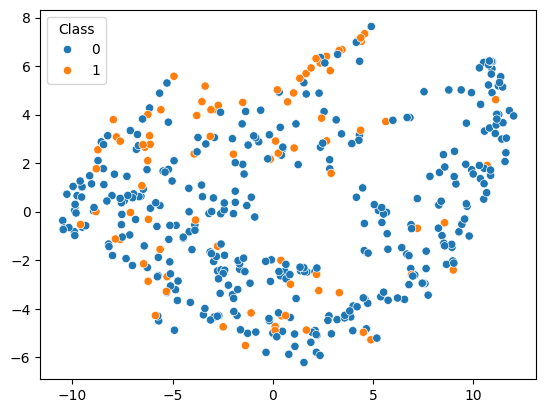

In [10]:
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=y_train)

In [59]:
inertias = []
for k in range (1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

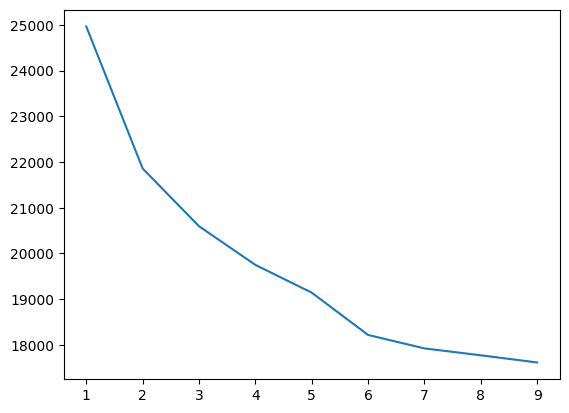

In [60]:
plt.plot(range(1, 10), inertias)

In [63]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_train)

(-5.0, 5.0)

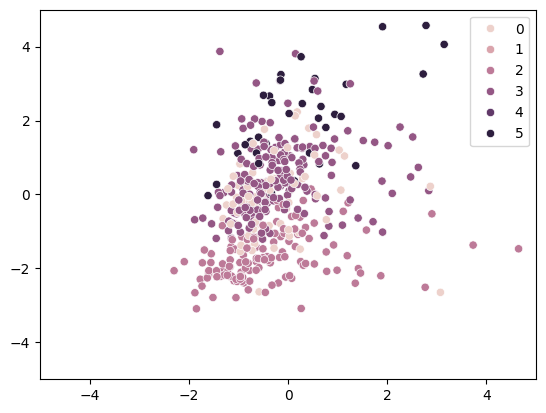

In [67]:
ax = plt.subplot()
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=clusters, ax=ax)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

In [76]:
pca.explained_variance_ratio_.cumsum()

array([0.14080376, 0.22230654, 0.28079699, 0.32947586, 0.37295789,
       0.41573935, 0.44790764, 0.47813311, 0.50690372, 0.53491428,
       0.55906763, 0.5816688 , 0.6028966 , 0.62317187, 0.64252963,
       0.66154016, 0.67888379, 0.69608218, 0.71269187, 0.72884074,
       0.74461963, 0.7596242 , 0.77431309, 0.7882946 , 0.80196524,
       0.81507704, 0.82771966, 0.83960052, 0.85074376, 0.86185108,
       0.87258975, 0.88257968, 0.89233265, 0.9010889 , 0.90958665,
       0.91796703, 0.92584705, 0.93323571, 0.94012073, 0.94692387,
       0.95336617, 0.95930205, 0.96510054, 0.97053289, 0.97537103,
       0.97975926, 0.98351901, 0.9868502 , 0.98967304, 0.99221014,
       0.99443368, 0.99624058, 0.9977645 , 0.99895293, 0.99941656,
       0.99976465])

In [82]:
smote = SMOTE(random_state=42)

In [83]:
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [93]:
svc = LogisticRegression(random_state=42)

In [94]:
svc.fit(X_train_resample, y_train_resample)

LogisticRegression(random_state=42)

In [95]:
svc.predict(X_test)

/home/tristannew/.pyenv/versions/3.12.2/envs/kaggle_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [96]:
y_test

Id
6c231f862f11    0
23ab7ab965d5    0
6ab2d09883de    1
9ba8bfa26e8a    0
d7dbf59b37f9    0
               ..
0aa059dad7f3    0
9230d1831db3    1
128cc82dc5d6    0
17d49f84524b    0
8767b93c7948    0
Name: Class, Length: 110, dtype: int64